# Final Project Part III: Stream processing and full APRS tranciever
Written by Miki Lustig

Updated by Josh Sanz Spring 2022, Drake Lin Spring 2023
____

In this part of the project we will take the functions that we wrote in the previous part and put them in a streaming architecture such that we can collect finite buffers and process them in real-time. 

We found some issues with the current implementation of ax25.py. The changes we made break Part II. So in this part we will use the file newax25.py instead.

In [1]:
# You can copy the compiled libpll.c from Part II or recompile pll.c with this command
!cc -fPIC -shared -o libpll.so pll.c

In [2]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import queue as Queue
import threading
import time
import sys
import multiprocessing

from numpy import ones, zeros, pi, sin, cos, exp, sign, r_, mean, power
from numpy.fft import fft, fftshift, ifft, ifftshift
from scipy import signal
from scipy import integrate

import bitarray
from scipy.io.wavfile import read as wavread
import newax25 as ax25
from math import gcd
import sounddevice as sd
import RPi.GPIO as GPIO
from functools import reduce
import base64

%matplotlib inline

In [3]:
# function to compute least common multiple
def lcm(numbers):
    return reduce(lambda x, y: (x*y)//gcd(x,y), numbers, 1)

### Pre-task 0: Audio Devices
* **Setup the software loopback and ensure that the various device indexes are correct, as in Part II.**

In [4]:
!sudo modprobe snd_aloop
!aplay -l | grep -i loopback

card 2: Loopback [Loopback], device 0: Loopback PCM [Loopback PCM]
card 2: Loopback [Loopback], device 1: Loopback PCM [Loopback PCM]


In [5]:
sd.query_devices()

   0 bcm2835 Headphones: - (hw:0,0), ALSA (0 in, 8 out)
   1 Fe-Pi Audio: HiFi sgtl5000-0 (hw:1,0), ALSA (2 in, 2 out)
   2 Loopback: PCM (hw:2,0), ALSA (32 in, 32 out)
   3 Loopback: PCM (hw:2,1), ALSA (32 in, 32 out)
   4 sysdefault, ALSA (0 in, 128 out)
   5 lavrate, ALSA (0 in, 128 out)
   6 samplerate, ALSA (0 in, 128 out)
   7 speexrate, ALSA (0 in, 128 out)
   8 pulse, ALSA (32 in, 32 out)
   9 upmix, ALSA (0 in, 8 out)
  10 vdownmix, ALSA (0 in, 6 out)
  11 dmix, ALSA (0 in, 2 out)
* 12 default, ALSA (32 in, 32 out)

In [6]:
builtin_idx = 0
usb_idx = 1
loop_idx = 3  # Use loopback dev 1! direwolf is connected to dev 0.
loop_idx_rcv = 2 # Use loopback dev 0. 
sd.default.samplerate = 48000
sd.default.channels = 1

### Pre-task 1: Direwolf
* **Copy the direwolf config from Part II to this directory.**
* **Start direwolf with ``./run-direwolf.sh`` in a separate terminal.**

In [7]:
# Start direwolf

## Creating a TNC (Terminal Node Controller, i.e. modem) class

The architecture we chose for this lab is to create a class that implements the functions of the modem, while keeping joint state variables such that it is possible to process buffers in real-time while maintaining continuity and integrity of the processing as if we are processing a single infinite buffer. 


We created the infrastructure for you, implemented in the `TNCaprs` class. 
It implements an overlap and save approach. The constructor for the class takes in the sampling frequency: `fs`, the size of soundDevice buffer (default is 1024): `Abuffer`, and the number of audio buffers to collect before processing: `Nchunks`.


##### `processBuffer(self, buff_in)`
The method `processBuffer(buff_in)` takes buffers in to be processed, collects them into a large buffer made of `Nchunks`. Once the large buffer has been collected, the method calls the demodulation method to create an NRZI, it calls the PLL to find the sampling timings, it samples the NRZI and converts it to NRZ bits. Finally it calls the function that looks for packets in the bitstream. 
The method implements an overlap and save approach. So, it calls the demodulation function with a buffer that is overlapping and expects a smaller buffer containing only valid linear convolution samples in return. 

##### `demod(self, buff)` -- same as `nc_afsk1200Demod`
Because there are 3 filters one after the other in the demodulator, each one of length N, the method `processBuffer(buff_in)` sends to `demod` a buffer sized `Nchunks*Abuffer + 3*(N-1)` and expects `Nchunks*Abuffer` samples in return. If you have different size filters, you need to modify `processBuffer(buff_in)` to account for that. The filters for `demod` are generated in the `__init__` function of the `TNCaprs` class. When filtering, use `np.convolve` with `mode='valid'` so that only valid linear convolution results are returned. 

##### ` PLL(self, NRZa)`
This is the same PLL implementation as before. The only difference is that the PLL counter: `pll`, its previous value: `ppll`, the stepsize: `dpll`, and the aggressiveness or nudge factor: `apll` are all class variables. This way, when the PLL finishes processing a buffer, the values are saved and used in the beginning of the next buffer.

##### ` FastPLL(self, NRZa)`
The same implementation of the PLL -- but a wrapper to a C-language function. This is much faster than the one written in python.

##### `findPackets(self,bits)`
This function is the same as before. The only differences are that the variables, `state`, `pktcounter`, and `packet`, are class variable and their value is kept from one call to another. 

Another difference is that we also added another variable: `bitpointer`. As you recall, the function looks for flags in the bitstream up to 7 bits before the end of the buffer. `bitpointer` is needed for the case where a flag is detected at the end of the buffer and extend to these 7 bits. That means that when we process the next buffer, we need to start after those bits, and `bitpointer` points to the bit we need to start with.

##### `modulate(self, bits)` -- same as `afsk1200`
Function takes bits and afsk1200 modulates them. The sampling rate is initialized in  `TNCaprs.__init__`.

##### `modulatePacket(self, callsign, digi, dest, info, preflags=80, postflags=80 )`
Given callsign, digipath, dest, info, number of pre-flags and post-flags, the function contructs an appropriate APRS packet, then converts it to NRZI and calls `modulate` to afsk1200 modulate the packet. 

### Task 1: 
* **We've converted functions `nc_afsk1200Demod` and  `afsk1200` to `TNCaprs.demod` and `TNCaprs.modulate`, read through the class and make sure you understand the functions

In [8]:
import numpy.ctypeslib as npct
from ctypes import c_int
from ctypes import c_float

array_1d_int = npct.ndpointer(dtype=np.int, ndim=1, flags='CONTIGUOUS')

libcd = npct.load_library("./libpll", ".")
libcd.pll.restype = c_int
libcd.pll.argtypes= [array_1d_int, c_int, array_1d_int,array_1d_int,  array_1d_int,array_1d_int, c_int, c_float]


class TNCaprs: 
    def __init__(self, fs=48000.0, Abuffer=1024, Nchunks=10):
        
        #  Implementation of an afsk1200 TNC. 
        #
        #  The TNC processes `Abuffer` long buffers until `Nchunks` number of buffers are 
        #  collected into a large one.
        #  This is because python is able to more efficiently process larger buffers than smaller ones.
        #  Then, the resulting large buffer is demodulated, sampled, and packets extracted.
        #
        # Inputs:
        #   fs      - sampling rate
        #   TBW     - TBW of the demodulator filters
        #   Abuffer - Input audio buffers from Pyaudio
        #   Nchunks - Number of audio buffers to collect before processing
        #   apll    - nudge factor of the PLL
        
        ## compute sizes based on inputs
        self.TBW = 2.0   # TBW for the demod filters
        self.N = (int(fs/1200*self.TBW)//2)*2+1   # length of the mark-space filters for demod
        self.fs = fs     # sampling rate   
        self.BW = 1200      # BW of filter based on TBW
        self.Abuffer = Abuffer             # size of audio buffer
        self.Nchunks = Nchunks             # number of audio buffers to collect
        self.Nbuffer = Abuffer*Nchunks+(self.N*3-3)         # length of the large buffer for processing
        self.Ns = 1.0*fs/1200.0 # samples per symbol
        
        ## state variables for the modulator
        self.prev_ph = 0  # previous phase to maintain continuous phase when recalling the function
        
        ## generate filters for the demodulator
        self.h_lp = signal.firwin(self.N,self.BW/fs*1.0,window='hanning')
        self.h_lpp = signal.firwin(self.N,self.BW*2*1.2/fs,window='hanning')
        self.h_space = self.h_lp*exp(1j*2*pi*(2200)*(r_[0:self.N]-self.N//2)/fs)
        self.h_mark = self.h_lp*exp(1j*2*pi*(1200)*(r_[0:self.N]-self.N//2)/fs)
        self.h_bp = signal.firwin(self.N,self.BW/fs*2.2,window='hanning')*exp(1j*2*pi*1700*(r_[0:self.N]-self.N//2)/fs)

        ## PLL state variables  -- so continuity between buffers is preserved
        self.dpll = np.round(2.0**32 / self.Ns).astype(np.int32)    # PLL step
        self.pll = 0                # PLL counter
        self.ppll = -self.dpll       # PLL counter previous value -- to detect overflow
        self.apll = 0.74             # PLL agressivness (small more agressive)
    
        ## state variable to NRZI2NRZ
        self.NRZIprevBit = bool(1)  
        
        ## State variables for findPackets
        self.state = 'search'   # state variable: 'search' or 'pkt'
        self.pktcounter = 0   # counts the length of a packet
        self.packet = bitarray.bitarray([0,1,1,1,1,1,1,0]) # current packet being collected
        self.bitpointer = 0   # pointer to advance the search beyond what was already 
                              # searched in the previous buffer

        ## state variables for processBuffer
        self.buff = zeros(self.Nbuffer)   # large overlap-save buffer
        self.chunk_count = 0              # chunk counter
        # bits from end of prev buffer to be copied to beginning of new
        self.oldbits = bitarray.bitarray([0,0,0,0,0,0,0])    
        self.Npackets = 0                 # packet counter
        
    
    def NRZ2NRZI(self,NRZ, prevBit=True):
        NRZI = NRZ.copy() 
        for n in range(0,len(NRZ)):
            if NRZ[n] :
                NRZI[n] = prevBit
            else:
                NRZI[n] = not(prevBit)
            prevBit = NRZI[n]
        return NRZI
    

    def NRZI2NRZ(self, NRZI):  
        NRZ = NRZI.copy() 
        for n in range(0,len(NRZI)):
            NRZ[n] = NRZI[n] == self.NRZIprevBit
            self.NRZIprevBit = NRZI[n]
        return NRZ
    
    
    def KISS2bits(self,KISS):
        # function that takes a KISS frame sent via TCP/IP and converts it to an APRSpacket bit stream.
        bits = bitarray.bitarray(endian="little")
        bits.frombytes(KISS)
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
        
        bits.frombytes(fcs.digest())
        return bitarray.bitarray('01111110') + ax25.bit_stuff(bits) + bitarray.bitarray('01111110') 
     
        
    def bits2KISS(self,bits):
        # function that takes a bitstream of an APRS-packet, removes flags and FCS and unstuffs the bits
        bitsu = ax25.bit_unstuff(bits[8:-8])
        return  bitsu[:-16].tobytes() 
    
    
    def modulate(self,bits):
        # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, 
        # sampled at fs Hz
        #  Inputs:
        #         bits  - bitarray of bits
        #         fs    - sampling rate
        # Outputs:
        #         sig    -  returns afsk1200 modulated signal
        
        fss = lcm((1200,self.fs))
        deci = fss//self.fs
    
        Nb = fss//1200
        nb = len(bits)
        NRZ = ones((nb,Nb))
        for n in range(0,nb):
            if bits[n]:
                NRZ[n,:]=-NRZ[n,:]
    
        freq = 1700 + 500*NRZ.ravel()
        ph = self.prev_ph + 2.0*pi*integrate.cumtrapz(freq)/fss
        sig = cos(ph[::deci])       
        return sig 
    
    
    def modulatePacket(self, callsign, digi, dest, info, preflags=80, postflags=80):
        # given callsign, digipath, dest, info, number of pre-flags and post-flags, the function contructs
        # an appropriate APRS packet, then converts it to NRZI and calls `modulate` 
        # to afsk1200 modulate the packet. 
        
        packet = ax25.UI(destination=dest,source=callsign, info=info, digipeaters=digi.split(b','),)
        prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(preflags,)).tolist())
        suffix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(postflags,)).tolist())
        sig = self.modulate(self.NRZ2NRZI(prefix + packet.unparse()+suffix))

        return sig
    

    def demod(self, buff):
        # Demodulates a buffer and returns NRZa. Make sure you only return valid samples.
    
        SIG = np.convolve(buff,self.h_bp,mode='valid')
        NRZa = abs(np.convolve(SIG,self.h_mark,mode='valid')) - abs(np.convolve(SIG,self.h_space,mode='valid'))
        NRZa = np.convolve(NRZa,self.h_lpp,mode='valid')
        return NRZa


    def FastPLL(self,NRZa):
        recbits = np.zeros(len(NRZa)//(self.fs//1200)*2,dtype=np.int32)
        pll = np.zeros(1,dtype = np.int32)
        pll[0] = self.pll
        ppll = np.zeros(1,dtype = np.int32)
        ppll[0] = self.ppll
                
        NRZb = (NRZa > 0).astype(np.int32)
        tot = libcd.pll(NRZb,len(NRZb),recbits,recbits,pll,ppll,self.dpll,self.apll)
        
        self.ppll = ppll.copy()
        self.pll = pll.copy()
        
        return bitarray.bitarray(recbits[:tot].tolist())
    
    
    def PLL(self, NRZa):
        idx = zeros(len(NRZa)//int(self.Ns)*2)   # allocate space to save indices        
        c = 0
        
        for n in range(1,len(NRZa)):
            if (self.pll < 0) and (self.ppll >0):
                idx[c] = n
                c = c+1
        
            if (NRZa[n] >= 0) !=  (NRZa[n-1] >=0):
                self.pll = np.int32(self.pll*self.apll)    
        
            self.ppll = self.pll
            self.pll = np.int32(self.pll+ self.dpll)
    
        return idx[:c].astype(np.int32) 
    

    def findPackets(self,bits):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
        flg = bitarray.bitarray([0,1,1,1,1,1,1,0])
        packets = []
        n = self.bitpointer
        
        # Loop over bits
        while (n < len(bits)-7) :
            # default state is searching for packets
            if self.state is 'search':
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+7] == flg[1:]:
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    self.state = 'pkt'
                    self.packet=flg.copy()
                    self.pktcounter = 8
                    # Advance to the end of the flag
                    n = n + 7
                else:
                    # flag was not found, advance by 1
                    n = n + 1             
            # state is to collect packet data. 
            elif self.state is 'pkt':
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+7] == flg[:7]:
                    # Flag detected, check if packet is longer than some minimum
                    if self.pktcounter > 200:
                        #print('packet found!')
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        self.state = 'search'
                        self.packet.extend(flg)
                        packets.append(self.packet.copy())
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        self.state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if self.pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer        
                        self.packet.append(bits[n])
                        self.pktcounter = self.pktcounter + 1
                        n = n + 1
                    else:  #runaway packet
                        #runaway packet, switch state to searching, and advance pointer
                        self.state = 'search'
                        n = n + 1
        
        self.bitpointer = n-(len(bits)-7) 
        return packets

    
    # function to generate a checksum for validating packets
    def genfcs(self,bits):
        # Generates a checksum from packet bits
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
    
        digest = bitarray.bitarray(endian="little")
        digest.frombytes(fcs.digest())

        return digest


    # function to parse packet bits to information
    def decodeAX25(self,bits, deepsearch=False):
        ax = ax25.AX25()
        ax.info = "bad packet"
        ax.parse(bits)
        return ax
    
    
    def processBuffer(self, buff_in):
        # function processes an audio buffer. It collect several small into a large one
        # Then it demodulates and finds packets.
        #
        # The function uses overlap and save convolution
        # The function returns packets when they become available. Otherwise, returns empty list
        
        N = self.N
        NN = N*3 - 3
        
        Nchunks = self.Nchunks
        Abuffer = self.Abuffer
        fs = self.fs
        Ns = self.Ns
        
        validPackets=[]
        packets=[]
        NRZI=[]
        idx = []
        bits = []
        
        # Fill in buffer at the right place
        self.buff[NN+self.chunk_count*Abuffer:NN+(self.chunk_count+1)*Abuffer] = buff_in.copy()
        self.chunk_count = self.chunk_count + 1  
        
        # number of chunk reached -- process large buffer
        if self.chunk_count == Nchunks:
            # Demodulate to get NRZI
            NRZI = self.demod(self.buff)
            
            # compute sampling points, using PLL
            bits = self.FastPLL(NRZI)
            # In case that buffer is too small, raise an error -- must have at least 7 bits worth
            if len(bits) < 7:
                raise ValueError('number of bits too small for buffer')
            
            # concatenate end of previous buffer to current one
            bits = self.oldbits + self.NRZI2NRZ(bits)
            
            # store end of bit buffer to next buffer
            self.oldbits = bits[-7:].copy()
            
            # look for packets
            packets = self.findPackets(bits)
            
            # Copy end of sample buffer to the beginning of the next (overlap and save)
            self.buff[:NN] = self.buff[-NN:].copy()
            
            # reset chunk counter
            self.chunk_count = 0
            
            # checksum test for all detected packets
            for n in range(0,len(packets)):
                if len(packets[n]) > 200: 
                    try:
                        ax = self.decodeAX25(packets[n])
                    except:
                        ax = ax25.AX25()
                        ax.info = "bad packet"
                    if ax.info != 'bad packet' and ax.info != 'no decode':
                        validPackets.append(packets[n])                
  
        return validPackets

## Testing the modem reception

Now, we are ready to test our modem. Let's first load the ISS recording and see if our modem can detect the 24 packets we detected earlier. The difference is that we will load data in small buffers of 1024 samples and process them over a larger buffer made of several small buffers.  There are two points to make here. First: the idea is that no matter what size of buffers you use, the result of the overlap and save should be the same. If it isn't, then you have a bug.... and believe us... we had many before we got it right. Second: Generally, there are some overheads associated with operating on different sized buffers. The performances will vary with different architectures and memory.  We will look at several sizes and measure the time to process about 9 million samples (3.4 min at 44.1 kHz).

### Task 2:

* **Copy `ISS.wav` from Part II and load it.**
* **Create a TNC object** using `modem = TNCaprs(fs=fs, Abuffer=1024, Nchunks=1)`.
* **Process the samples with the modem,** 1024 samples at a time, using `packets = modem.processBuffer(sig[n:n+Abuffer])`. The method `modem.processBuffer` will return a non-empty object whenever it detects packets. 
* **Iterate on the returned objects and display the packets.**

Todo:

* **First set `Nchunks=10`**, meaning you will call the demodulation and decoding code every 1024/44100 = 23 ms when `Nchunks=1`.

* **Now, repeat for `Nchunks=10`**. This means you will be performing demodulation and decoding on a buffer of size 1024*10 corresponding to 232 ms. Do you see improvement in the overall performance?

* **Now, repeat for `Nchunks=100`** (\~2.3 s) -- the buffer size will also have associated delay before packets are presented, which in some situations can be a problem when timely response is needed. 


In [9]:
!cp ../part2/ISS.wav .

In [10]:
fs, sig = wavread("ISS.wav")

In [11]:
Abuffer = 1024
Nchunks = 100

modem = TNCaprs(fs=fs, Abuffer=Abuffer, Nchunks=Nchunks)

starttime = time.time()
npack = 0
for n in range(0,len(sig),Abuffer):
    packets = modem.processBuffer(sig[n:n+Abuffer])
    for pkt in packets: 
        npack = npack + 1
        ax = modem.decodeAX25(pkt)
        infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.strip()
                    }
        print(infostr)
 
print("Processing took:", time.time()-starttime)

 1) | DEST: CQ    0 | SRC: RS0ISS | DIGI: () | >ARISS - International Space Station |
 2) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | =4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH! |
 3) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | >CQCQCQ |
 4) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | HELO VIA THE ISS |
 5) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp |  |
 6) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp |  |
 7) | DEST: ARISS p | SRC: KF1BUZ | DIGI: RS0ISSpAPRS  0WIDE2 2SGATE 0ISS   0IGATE 0PCSAT 0BEACON0 | =3932.15N/11951.16Wy.kf1buz and k1gem say hi from reno nv |
 8) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp |  |
 9) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | >from DM43 |
 10) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | =4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH! |
 11) | DEST: CQ  ! 0 | SRC: K1RvM, | DIGI: RS0ISSp |  |
 12) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | HELLO VIA THE ISS |
 13) | DEST: C

## Sending Files in Loopback

We will define a specific format for sending files through APRS that will allow your course staff to receive and reconstruct them for display on a server. For each packet, the `source` will be your callsign + ssid. The `destination` will be APCAL (remember, the destination actually defines the version of software we are using). Packets will be of Message type with addressee yourself, your partner, or EE123.

#### Custom Packet Format
The body of the first packet contains START, a 4-digit unique ID, a filename you want the received data to be saved as, and a comment (allowed to be blank) separated by commas. The info field thus looks like

``:TGTCALL :START####,filename,comment here``

`"{:04d}".format(uid)` ensures that your number is left-padded with 0s to fill 4 digits.

The bodies of subsequent packets are filled with data, followed by a 4-digit sequence number to allow reconstruction if packets arrive out of order at a receiver. Be careful not to exceed the length of the info field, as 15 bytes are taken up by the address and sequence number.

``:TGTCALL :<data data data>####``

#### Sending binary data
The APRS standard requires that, except for certain standard protocols, data be printable. We therefore encode any binary data we send as [base64](https://en.wikipedia.org/wiki/Base64), a format which is printable and also satisfies the recommendation that messages be representable with 7-bit encodings. We have written a function ``file_to_b64`` for you below which reads in a file and converts it to base64. We have also provided ``ee123_bitarr_to_base64`` and ``ee123_base64_to_bitarr`` which convert between bitarrays (possibly not of integer byte length) and base64. They will be useful later in your project. 

_Note that each of these encoding functions prepends the number of subsequent bytes or bits as a check for reconstruction later. When you write your reconstruction function you must handle this (uint32) feature._

The final packet after all data has been sent contains END and the unique ID again.

``:YOURCALL :END####``

You will write code that does the following: reads a file, breaks it into packets, modulates them and plays them in loopback mode. At the same time, records the played packets, demodulates them, and stores the information frame containing the data into a new file. 
Basically, a full file transfer in loopback mode. 

We will use this protocol to send the below image.


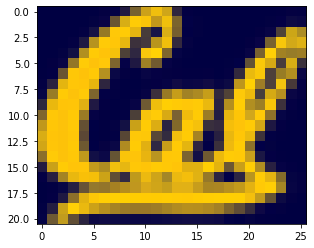

In [12]:
from PIL import Image
fname = "calBlue.tiff"
a = Image.open(fname)
plt.imshow(a);

### Task 5:

* **Read the `calBlue.tiff` file into a base64 bytes object with `file_to_b64`.**
* **Create a modem** using the TNCaprs with `fs=48000` Hz, `Abuffer=1024`, and `Nchunks=10`
* **Read 240 bytes from the file at a time, create APRS packets with the 240 bytes in the information field.**
* **Modulate the packets and push into a Queue named `Qout`.**

We have provided skeleton code for you in `enqueue_data`.


In [112]:
# Convert from bitarray class to b64 bytes and back
def ee123_bitarr_to_base64(bits: bitarray.bitarray):
    bN = np.uint32(len(bits)).tobytes()
    mybytes = bN + bits.tobytes()
    return base64.b64encode(mybytes)

def ee123_base64_to_bitarr(b64: str):
    mybytes = base64.b64decode(b64)  # Be careful not to overwrite the builtin bytes class!
    N = np.frombuffer(mybytes[:4], dtype='<u4')[0]
    ba = bitarray.bitarray()
    ba.frombytes(mybytes[4:])
    return ba[:N]

def file_to_b64(fname):
    with open(fname, 'rb') as f:
        raw = f.read()
    # Prepend the number of bytes before encoding
    b64 = base64.b64encode(np.uint32(len(raw)).tobytes() + raw)
    return b64

def enqueue_data(callsign, modem, data, address=None, uid=None, fname="myfile.bin", 
                 comment="UCB EE123 message format", dest=b"APCAL", bsize=240):
    """
    Inputs:
      callsign: your callsign
      modem: a modem object
      data: data to send as a bytes object
      address: address callsign for the message, defaults to your callsign
      uid: optionally specify a UID, otherwise one will be randomly chosen
      fname: filename to send in start packet
      comment: comment for start packet
      dest: should be APCAL for EE123 data
      bsize: number of bytes to send per packet
      
    Outputs:
      Qout: a queue containing modulated packets to transmit
      uid: the uid used for this data transfer
    """
    if address is None:
        address = callsign
    if uid is None:
        uid = np.random.randint(0, 10000)
    uid = bytes("{:04d}".format(uid), 'utf-8')
    print("Putting packets in Queue for transmission ID=%s" % uid.decode())
    
    Qout = Queue.Queue()
    
    Digi = b'WIDE1-1'

    # Enqueue START packet
    addr = bytes(':{:<9}:'.format(address), 'utf-8')
    # addr, START, uid, filename, comment
    start = b','.join([addr + b'START' + uid, bytes(fname, 'utf-8'), bytes(comment, 'utf-8')])
    tmp = modem.modulatePacket(callsign=callsign, digi=Digi, dest=dest, info=start)
    Qout.put(tmp)
    # Enqueue data packets
    idx = 0
    while True:
        seq = bytes('{:04d}'.format(idx), 'utf-8')
        info = addr + data[idx*bsize:idx*bsize+bsize] + seq
        print(len(info))
        tmp = modem.modulatePacket(callsign=callsign, digi=Digi, dest=dest, info=info)
        Qout.put(tmp)
        
        idx += 1
        if idx * bsize > len(data):
            break
    # Enqueue END packet
    end = addr + b'END' + uid
    tmp = modem.modulatePacket(callsign=callsign, digi=Digi, dest=dest, info=end)
    Qout.put(tmp)

    return Qout, uid
    

In [107]:
callsign = "EE1235-1"
fs = 48000
modem = TNCaprs(fs=fs, Abuffer=1024, Nchunks=10)
fname = "calBlue.tiff"

print("Putting packets in Queue")

# Enqueue the file
file_b64 = file_to_b64(fname)
Qout, uid = enqueue_data(
    callsign,
    modem,
    file_b64,
    fname=fname
)

print("Done. UID=%s" % uid.decode())
print(f"There are {Qout.qsize()} packets in Qout")

Putting packets in Queue
b'\xa6\x0e\x00\x00'
Putting packets in Queue for transmission ID=2697
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
223
Done. UID=2697
There are 23 packets in Qout


### Task 6:
We provide a replay callback similar to Lab 4. The callback stores samples from the loopback into a queue named ``Qin`` and also plays the samples on the specified audio device, so you can hear it. *Don't forget to stop direwolf while running this section.*

* **Start the record-play stream.** 
* **While samples are being recorded and pushed to ``Qin`` in the background, read the packets from `Qout` and play each packet** on the loopback audio using sd.play() with ``blocking=True``.
* **Add a 0.1 second delay between each packet transmission.** You will need to increase this delay when sending to direwolf, or direwolf will drop packets to prevent the user from hogging the APRS channel.

Warning: this will take approximately 1 minute and sound very annoying!

In [100]:
# Define the callback factory so we can specify which non-global queue we want
def make_QR_callback(Qin):
    def queueREPLAY_callback(indata, outdata, frames, time, status):
#         assert frames == 1024
        if status:
            print(status)
        outdata[:] = indata
        Qin.put(indata.copy()[:, 0]) # Global queue
    return queueREPLAY_callback

In [101]:
Qin = Queue.Queue()
# This stream captures samples on loopback_rcv and plays them on the built in device.
# Remember that loopback is connected to loopback_rcv.
st_replay = sd.Stream(device=(loop_idx_rcv, builtin_idx), blocksize=modem.Abuffer, callback=make_QR_callback(Qin))
print("Starting stream")
st_replay.start()
starttime = time.time()

N = Qout.qsize()
n = 0
while not Qout.empty():
    n = n+1
    tmp = Qout.get()
    time.sleep(0.1)
    sd.play(0.4*tmp,samplerate=fs,blocking=True,device=loop_idx)
    print("played packet #%d of %d" % (n,N))    

# Remember, we have to stop and close the stream.
st_replay.stop()
st_replay.close()

print(f"Done: {time.time() - starttime:.2f} s")
print(f"There are {Qin.qsize()} buffers in Qin")

Starting stream
played packet #1 of 23
played packet #2 of 23
played packet #3 of 23
played packet #4 of 23
played packet #5 of 23
played packet #6 of 23
played packet #7 of 23
played packet #8 of 23
played packet #9 of 23
played packet #10 of 23
played packet #11 of 23
played packet #12 of 23
played packet #13 of 23
played packet #14 of 23
played packet #15 of 23
played packet #16 of 23
played packet #17 of 23
played packet #18 of 23
played packet #19 of 23
played packet #20 of 23
played packet #21 of 23
played packet #22 of 23
played packet #23 of 23
Done: 67.88 s
There are 3181 buffers in Qin


In [102]:
# Remember, we have to stop and close the stream.
st_replay.stop()
st_replay.close()

### Task 7:
Now we will receive and reassemble a file transmitted over the loopback interface.

* **Using the recording in Qin from Task 6, find and extract packets** with ``modem.processBuffer``.
* **Decode the packets** with ``modem.decodeAX25``
* **Write a function ``decode_ee123_message``** to extract relevant information from the info field of a packet.
* **Record the unique ID of the transmission.**
* **Collect the transmitted base64 data and decode it** (you may want to use ``base64.b64decode``).
* **Write the data to an appropriately named file.**
* **Show the reconstructed image.**

In [103]:
def decode_ee123_message(msg):
    """
    Input:
      msg: The info field of an APRS message packet
    
    Output:
      A dict containing the key components the packet may contain
      
    Message formats:
    :CALLSIGN :START####,filename,comment
    :CALLSIGN :<data data data>####
    :CALLSIGN :END####
    """
    msg = msg.strip()
    addressee = ''
    uid = None
    isstart = False
    isend = False
    seq = None
    data = None  # This should be a bytes object
    filename = ''
    comment = ''
    
    # Your code here:
    # First item is empty due to space
    msg = msg.split(":")[1:]
    # Callsign
    addressee = msg.pop(0)
    # Check start, end, or data
    msg_type = msg.pop(0)
    
    if msg_type.find("START") >= 0:
        isstart = True
        uid = msg_type[-4:]
        body = msg_type.split(',')
        body.pop(0)
        filename = body.pop(0)
        comment = body.pop(0)
    elif msg_type.find("END") >= 0:
        isend = True
        uid = msg_type[-4:]
    else:
        # Data Type
        b64dat = msg_type[0:-4]
        seq = msg_type[-4:]
        data = base64.b64decode(b64dat)

    # End of your code
    return {'addr': addressee, 'uid': uid, 'isstart': isstart, 
            'isend': isend, 'seq': seq, 'filename': filename, 
            'data': data, 'comment': comment}

In [104]:
# Decode the recording
print("decoding packets")
starttime = time.time()

# Your code here:
msg = []
while not Qin.empty():
    tmp = Qin.get()
    packets = modem.processBuffer(tmp)
    for pckt in packets:
        ax = modem.decodeAX25(pckt)
        print(ax.info)
        msg.append(decode_ee123_message(ax.info))

decoding packets
:EE1235-1 :START8865,calBlue.tiff,UCB EE123 message format
:EE1235-1 :pg4AAElJKgAIAAAACwAAAQQAAQAAABoAAAABAQQAAQAAABUAAAACAQMAAwAAAJIAAAADAQMAAQAAAAEAAAAGAQMAAQAAAAIAAAARAQQAAQAAAEAIAAAVAQMAAQAAAAMAAAAWAQQAAQAAABUAAAAXAQQAAQAAAGYGAAAcAQMAAQAAAAEAAABzhwcAqAcAAJgAAAAAAAAACAAIAAgAAAAHqGFwcGwCIAAAbW50clJHQiBYWVog0000
:EE1235-1 :B9kAAgAZAAsAGgALYWNzcEFQUEwAAAAAYXBwbAAAAAAAAAAAAAAAAAAAAAAAAPbWAAEAAAAA0y1hcHBsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALZGVzYwAAAQgAAABvZHNjbQAAAXgAAAVsY3BydAAABuQAAAA4d3RwdAAABxwAAAAUclhZWgAABzAAAAAUZ1hZWgAAB0QAAAAU0001
:EE1235-1 :YlhZWgAAB1gAAAAUclRSQwAAB2wAAAAOY2hhZAAAB3wAAAAsYlRSQwAAB2wAAAAOZ1RSQwAAB2wAAAAOZGVzYwAAAAAAAAAUR2VuZXJpYyBSR0IgUHJvZmlsZQAAAAAAAAAAAAAAFEdlbmVyaWMgUkdCIFByb2ZpbGUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAG1sdWMAAAAA0002
:EE1235-1 :AAAAHgAAAAxza1NLAAAAKAAAAXhockhSAAAAKAAAAaBjYUVTAAAAJAAAAchwdEJSAAAAJgAAAex1a1VBAAAAKgAAAhJmckZVAAAAKAAAAjx6aFRXAAAAFgAAAmRpdElUAAAAKAAAAnpuYk5PA

In [109]:
data = [m for m in msg if not (m['isstart'] or m['isend'])]
data_sorted = sorted(data, key=lambda d: int(d['seq'], 16))
binary = b''.join([d['data'] for d in data_sorted])[4:]
rec_fname = "rec_" + [m['filename'] for m in msg if m['isstart']][0]
print(rec_fname)

# End of your code
# Save the reconstructed file
with open(rec_fname, 'wb') as f:
    f.write(binary)

print(f"Done: {time.time() - starttime:.2f} s")

rec_calBlue.tiff
Done: 119.31 s


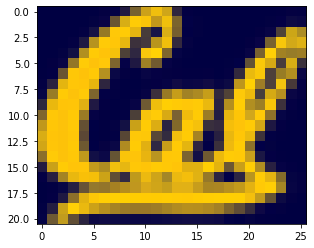

In [110]:
from PIL import Image
path = rec_fname
a = Image.open(path)
plt.imshow(a);

### Task 9:
Now repeat the above steps, but instead of sending the packet to yourself send it to your partner via direwolf.

* **Start direwolf if not already running** with `./run-direwolf.sh` in a terminal.
* **Generate a queue of messages** to send to your partner, with their callsign as the message address.
* **Send the messages**, with sufficient delays to avoid dropped messages (max 15/minute), over loopback to direwolf.
* Your partner should be receiving and their direwolf position beacon should be within 50km of yours to pass the serverside filters.
* You may want to adjust the direwolf config to set the local filter to ``t/m`` instead of ``t/mwnps`` so that your 15 packets per second are not taken by messages from other people.
* **Repeat these steps so that you receive a file from your partner.**

Part of the APRS protocol specifies that when a message received from APRS-IS is retransmitted over RF, it should be wrapped in a 3rd Party Header. See the [standard](http://www.aprs.org/doc/APRS101.PDF) page 95 for more details. The extra information in a 3rd Party Header takes up 20 or more bytes in the info field of an AX.25 packet, reducing the maximum number of bytes we can safely transmit in a single packet. However, the APRS-IS servers and, most importantly, direwolf are able to handle longer packets which break the standard for safety when dealing with unusual character encodings. We can take advantage of that fact for the purpose of this project to avoid truncating the data in each packet even more than we already have to. 

**DO NOT send messages of this length if you expect them to actually be transmitted over RF, as you could cause other hams' equipment to crash.** 

We know that our direwolf IGates are connected directly to the modem via a software loopback, so we are _probably_ ok. 

We have modified newax25.py to automatically recurse into 3rd Party Header packets and decode the nested packet, which contains the information we want for this project. If you write your own TNC code someday, be wary of this case.

In [21]:
# Send a message to your partner

# Create the message queue
callsign = TODO
partner_callsign = TODO
fs = 48000
modem = TNCaprs(fs=fs, Abuffer=1024, Nchunks=10)
fname = "hello.txt"

print("Putting packets in Queue")

# Enqueue the file and send
file_b64 = file_to_b64(fname)
Qout, uid = enqueue_data(callsign, modem, file_b64, address=partner_callsign, fname="hello.txt")

print("Done. UID=%s" % uid.decode())
    
Qin = Queue.Queue()
print("Starting transmission")
starttime = time.time()
# Modulate and send
while not Qout.empty():
    tmp = Qout.get()
    time.sleep(0.5)
    sd.play(0.4*tmp,samplerate=fs,blocking=True,device=loop_idx)

print(f"Done: {time.time() - starttime:.2f} s")

In [26]:
# Receive a message from your partner

fs = 48000
modem = TNCaprs(fs=fs, Abuffer=1024, Nchunks=10)

Qin = Queue.Queue()
# This stream captures samples from direwolf on loopback and plays them on the built in device.
# Remember that loopback is connected to loopback_rcv.
st_replay = sd.Stream(device=(loop_idx, builtin_idx), blocksize=modem.Abuffer, callback=make_QR_callback(Qin))
print("Starting stream")
st_replay.start()
starttime = time.time()

print("decoding packets")

# Your code here:

# End of your code

# Save the reconstructed file
print("Saving as rec_" + rec_fname)
with open("rec_" + rec_fname, 'wb') as f:
    f.write(binary)
        
print(f"Done: {time.time() - starttime:.2f} s")

In [ ]:
st_replay.stop()
st_replay.close()

### Task 10:
Now check your file transfer protocol for compatibility with our server. 
* **Send `text.png` to NU6XB, then check our [server](http://igen2.eecs.berkeley.edu/packets) to make sure the file shows up and is able to be displayed in your browser.** You may want to try sending a smaller file (like `hello.txt`) first for debugging.

In [113]:
# Send to our server

# Create the message queue
callsign = "EE1235-1"
partner_callsign = "NU6XB"
fs = 48000
modem = TNCaprs(fs=fs, Abuffer=1024, Nchunks=10)
fname = "text.png"

print("Putting packets in Queue")

# Enqueue and send the file
file_b64 = file_to_b64(fname)

Qout, uid = enqueue_data(callsign, modem, file_b64, address=partner_callsign, fname=fname)

print("Done. UID=%s" % uid.decode())
    
# Modulate and send
Qin = Queue.Queue()
print("Starting transmission")
starttime = time.time()

N = Qout.qsize()
n = 0
while not Qout.empty():
    n = n+1
    tmp = Qout.get()
    time.sleep(0.5)
    sd.play(0.4*tmp,samplerate=fs,blocking=True,device=loop_idx)
    print("Sent packet #%d out of %d" %(n,N))

print(f"Done: {time.time() - starttime:.2f} s")

Putting packets in Queue
Putting packets in Queue for transmission ID=8797
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
251
Done. UID=8797
Starting transmission
Sent packet #1 out of 68
Sent packet #2 out of 68
Sent packet #3 out of 68
Sent packet #4 out of 68
Sent packet #5 out of 68
Sent packet #6 out of 68
Sent packet #7 out of 68
Sent packet #8 out of 68
Sent packet #9 out of 68
Sent packet #10 out of 68
Sent packet #11 out of 68
Sent packet #12 out of 68
Sent packet #13 out of 68
Sent packet #14 out of 68
Sent packet #15 out of 68
Sent packet #16 out of 68
Sent packet #17 out of 68
Sent packet #18 out of 68
Sent packet #19 out of 68
Sent packet #20 out of 68
Sent packet #21 out of 68
Sent packet #22 out of 68
Sent packet #23 out of 68
Sent packet #24 out of 68
Sent pack